In [204]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

%matplotlib inline

In [205]:
# read data
df = pd.read_csv('../data/player_statistics.csv')

In [206]:
# Load match_info.csv
match_info = pd.read_csv('../data/match_info.csv')

# Merge the age column into df based on match_id
df = df.merge(match_info[['match_id', 'age']], on='match_id', how='right')

All speeds are in meters per second. Distances are in meter and times are in seconds. The speed zones, however, are noted as kilometers per hour so that the first speed zone is within 0 km/h and 5 km/h, the second between 5 km/h and 10 km/h.

In [207]:
# divide columns into relevant lists
info_vars = ['tournament_id', 'match_id', 'player_id', 'team', 'age']
speed_vars = ['top_speed_first', 'top_speed_second', 'avg_speed_with_ball_first', 'avg_speed_with_ball_second']
time_vars = ['onfield_time_first', 'onfield_time_second']
dist_vars = ['distance_first', 'distance_second']
ac_de_vars = ['accelerations_first', 'accelerations_second', 'decelerations_first', 'decelerations_second']
zone_vars = ['time_in_speed_zone_0_5_first','time_in_speed_zone_0_5_second', 'time_in_speed_zone_5_10_first',
             'time_in_speed_zone_5_10_second', 'time_in_speed_zone_10_15_first','time_in_speed_zone_10_15_second',
             'time_in_speed_zone_15_20_first','time_in_speed_zone_15_20_second', 'time_in_speed_zone_20_25_first',
             'time_in_speed_zone_20_25_second', 'time_in_speed_zone_25_plus_first','time_in_speed_zone_25_plus_second']

In [208]:
# create average speed from time and distance variables and add to speed vars
df['avg_speed_first'] = df['distance_first']/df['onfield_time_first']
df['avg_speed_second'] = df['distance_second']/df['onfield_time_second']

speed_vars.append('avg_speed_first')
speed_vars.append('avg_speed_second')

# reorder columns
df = df[info_vars + speed_vars + time_vars + dist_vars + ac_de_vars + zone_vars]
df.head()

,tournament_id,match_id,player_id,team,age,top_speed_first,top_speed_second,avg_speed_with_ball_first,avg_speed_with_ball_second,avg_speed_first,...,time_in_speed_zone_5_10_first,time_in_speed_zone_5_10_second,time_in_speed_zone_10_15_first,time_in_speed_zone_10_15_second,time_in_speed_zone_15_20_first,time_in_speed_zone_15_20_second,time_in_speed_zone_20_25_first,time_in_speed_zone_20_25_second,time_in_speed_zone_25_plus_first,time_in_speed_zone_25_plus_second
0,57,1256,7327,Home,F12,0.00,0.00,0.00,0.00,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,57,1256,7328,Home,F12,6.21,7.18,1.80,2.25,1.986644,...,438.40,400.30,203.66,163.28,62.56,64.46,14.06,20.38,5.54,6.02
2,57,1256,7329,Home,F12,0.00,7.35,0.00,2.75,NaN,...,0.00,411.52,0.00,193.66,0.00,71.50,0.00,23.96,0.00,10.76
3,57,1256,7330,Home,F12,0.00,0.00,0.00,0.00,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,57,1256,7331,Home,F12,6.19,0.00,1.83,0.00,1.672697,...,398.42,0.00,131.68,0.00,50.26,0.00,6.40,0.00,1.98,0.00


In [209]:
# Combine speed zones for the whole match using iteration
for zone in ['0_5', '5_10', '10_15', '15_20', '20_25', '25_plus']:
    df[f'time_in_speed_zone_{zone}'] = df[f'time_in_speed_zone_{zone}_first'] + df[f'time_in_speed_zone_{zone}_second']
    zone_vars.append(f"time_in_speed_zone_{zone}")

#### Distribution of velocity per age group

In [210]:
#define x-axis values
x = np.linspace(0, 40, 100) 

#calculate pdf of Gamma distribution for each x-value
y = stats.gamma.pdf(x, a=2, scale=5)

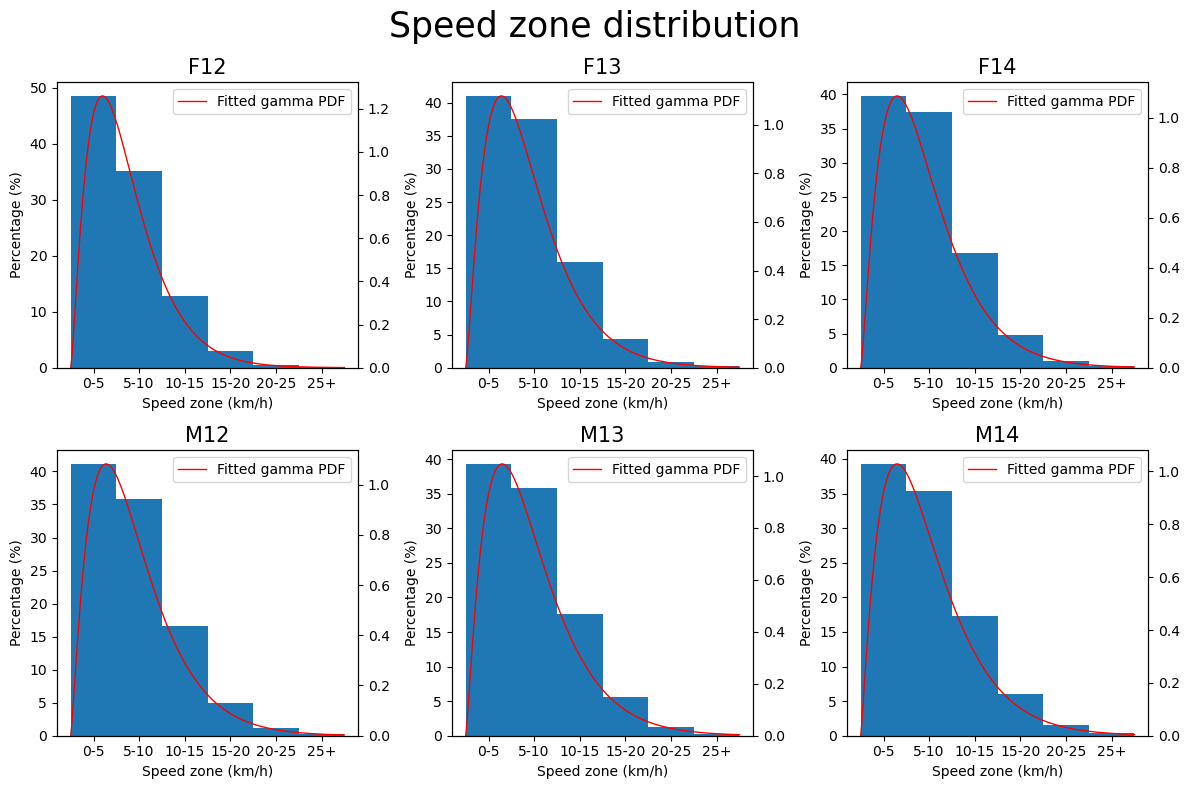

In [221]:
# plot tempo in a line plot by age groups
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

df_grouped = df.groupby('age')

# Shortened labels for speed zones
short_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25+']
bin_midpoints = np.array([2.5, 7.5, 12.5, 17.5, 22.5, 27.5])

bar_width = 5 # width of the speed zone (0-5, 5-10, etc.)

# save gamma parameters
gamma_params_dict = {}

for i, (group_name, df_group) in enumerate(df_grouped):
    df_zones = df_group[zone_vars]

    speed_zone_columns = [col for col in df_zones.columns if ("first" not in col) and ("second" not in col)]

    # Sum the absolute time spent in each speed zone across all matches
    summed_zones = df_zones[speed_zone_columns].sum()

    # Normalize summed values to percentages
    total_time = summed_zones.sum()
    percentage_zones = (summed_zones / total_time) * 100

    # Reconstruct pseudo-speed data for fitting (or use real speeds if available)
    pseudo_speeds = np.repeat(bin_midpoints, (percentage_zones.values * 10).astype(int))  # scaling for sample size

    # Fit gamma distribution
    gamma_params = stats.gamma.fit(pseudo_speeds, floc=0)
    gamma_dist = stats.gamma(*gamma_params)

    # Save parameters for later use
    gamma_params_dict[group_name] = gamma_params

    # Generate x values for smooth curve
    x = np.linspace(0, 30, 300)
    pdf = gamma_dist.pdf(x)

    # Scale the PDF correctly
    bin_width = 5
    pdf_scaled = pdf * bin_width
    pdf_scaled = pdf_scaled / pdf_scaled.sum() * 100  # scale to percentage
    
    axes[i].bar(bin_midpoints, percentage_zones.values, width=bar_width)
    axes[i].set_title(group_name, fontsize=15)
    axes[i].set_xlabel('Speed zone (km/h)', fontsize=10)
    axes[i].set_ylabel('Percentage (%)', fontsize=10)
    axes[i].set_xticks(bin_midpoints)
    axes[i].set_xticklabels(short_labels)

    # Twin y-axis for the gamma PDF
    ax2 = axes[i].twinx()
    ax2.plot(x, pdf_scaled, color='red', linewidth=1, label='Fitted gamma PDF')
    ax2.tick_params(axis='y')
    ax2.set_ylim(0)  # Adjust y-axis limits for the PDF

    ax2.legend(loc='upper right')

fig.suptitle('Speed zone distribution', fontsize=25)
plt.tight_layout()